In [1]:
from typing import Any

from src.model_db.tiny_model_db import TinyModelDB

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from src.reinforcement_learning.algorithms.policy_mitosis.mitosis_policy_info import MitosisPolicyInfo
from src.model_db.model_db import ModelEntry



In [2]:
with TinyModelDB(base_path=f'E:/saved_models/rl/Humanoid-v4/mitosis-2024-05-18_02.04.34') as policy_db:
    policy_entries_sorted: list[ModelEntry[MitosisPolicyInfo]] = list(sorted(policy_db.all_entries(), key=lambda p: p['model_info']['score'], reverse=True))

In [3]:
for policy_entry in policy_entries_sorted:
    print(f"id = {policy_entry['model_id']}, score = {policy_entry['model_info']['score']:6.4f}, parent_id = {str(policy_entry['parent_model_id'])}")

id = 2024-05-18_03.08.02~8t3C3G, score = 90.2010, parent_id = 2024-05-18_02.50.20~Tw80dJ
id = 2024-05-18_03.13.49~XXwWEt, score = 87.0685, parent_id = 2024-05-18_03.08.05~SOsTBF
id = 2024-05-18_03.08.05~SOsTBF, score = 86.1669, parent_id = 2024-05-18_02.50.20~Tw80dJ
id = 2024-05-18_02.50.52~WfSPlL, score = 82.6602, parent_id = 2024-05-18_02.33.30~l99DVG
id = 2024-05-18_02.33.30~l99DVG, score = 80.3886, parent_id = 2024-05-18_02.27.41~nDJMf2
id = 2024-05-18_02.50.20~Tw80dJ, score = 80.2498, parent_id = 2024-05-18_02.33.30~l99DVG
id = 2024-05-18_02.33.25~w9PJcD, score = 79.2998, parent_id = 2024-05-18_02.04.36~iJLFQm
id = 2024-05-18_02.04.36~iJLFQm, score = 78.4315, parent_id = None
id = 2024-05-18_02.27.41~nDJMf2, score = 78.3870, parent_id = 2024-05-18_02.04.36~iJLFQm
id = 2024-05-18_02.04.36~E0JgPM, score = 78.0607, parent_id = None
id = 2024-05-18_02.27.28~fUslnN, score = 78.0343, parent_id = 2024-05-18_02.04.36~E0JgPM
id = 2024-05-18_02.39.14~ZHvPBQ, score = 77.4410, parent_id = 202

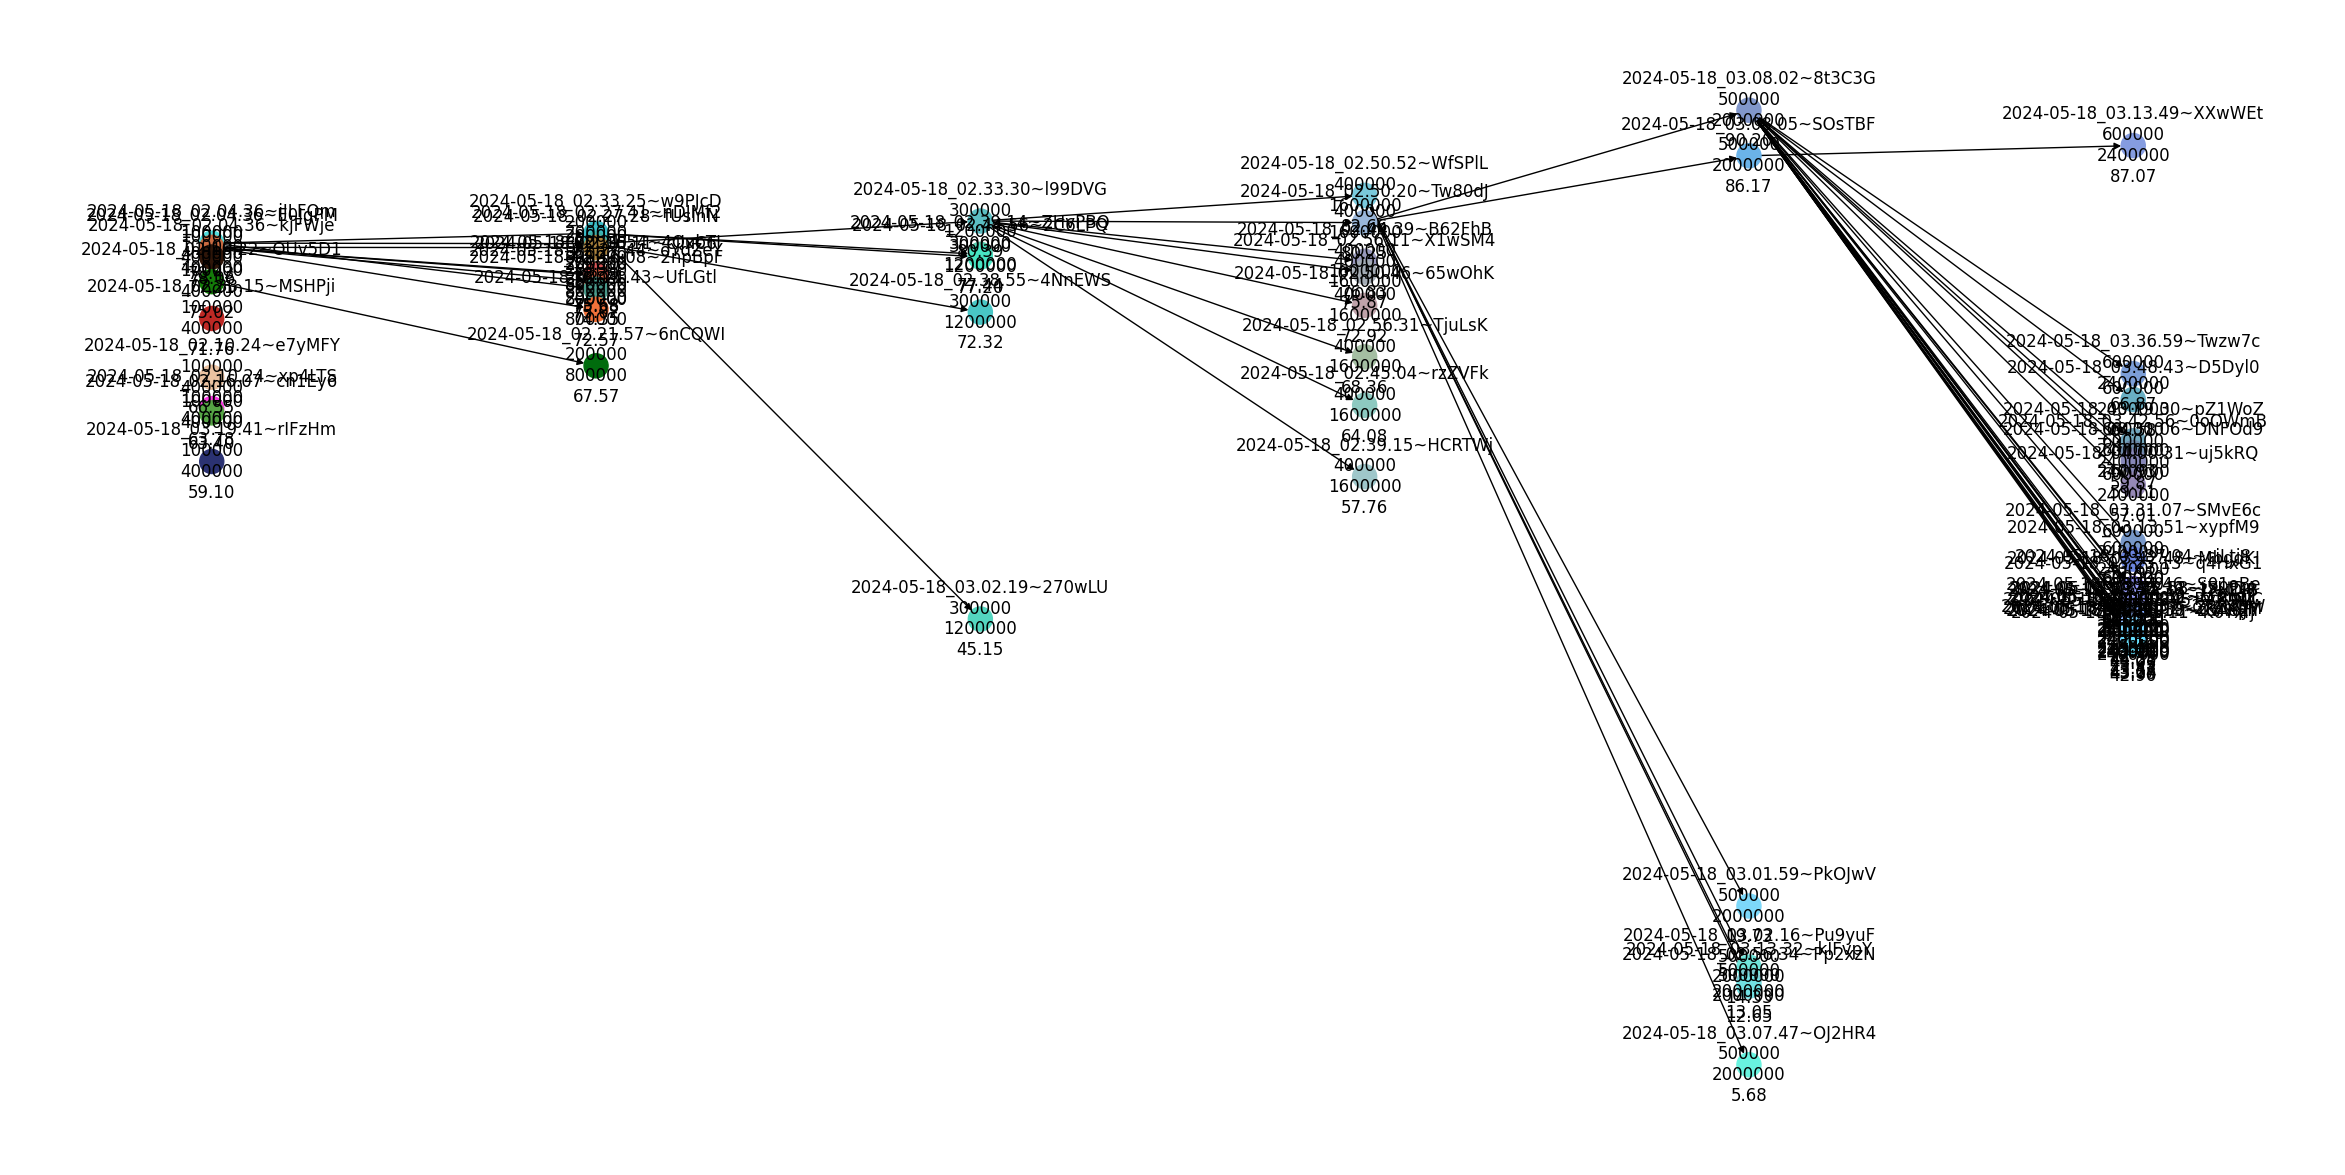

In [4]:
G = nx.DiGraph()

G.add_nodes_from(
    (policy_entry['model_id'], {
        'score': policy_entry['model_info']['score'], 
        'steps_trained': policy_entry['model_info']['steps_trained'],
        'env_steps_trained': policy_entry['model_info'].get('env_steps_trained', None)
    })
     for policy_entry 
     in policy_entries_sorted
     )

pos: dict[str, tuple[int, float]] = {}
for policy_entry in policy_entries_sorted:
    model_id = policy_entry['model_id']
    parent_id = policy_entry['parent_model_id']
    if parent_id is not None:
        G.add_edge(parent_id, model_id)
    
    model_info = policy_entry['model_info']
    pos[model_id] = (model_info['steps_trained'], model_info['score'])


def set_color_recursively(node_id: str, c: Any):
    colors[node_id] = c
    for neighbor_id in G.neighbors(node_id):
        c = np.clip(c + (np.random.random(3) - 0.5) / 4, 0, 1)
        set_color_recursively(neighbor_id, c)
    

colors: dict[str, np.ndarray] = {}
for root_id in (node for node, in_degree in G.in_degree() if in_degree == 0):
    color = list(np.random.random(3))
    set_color_recursively(root_id, color)

node_color = [colors[node_id] for node_id in G]

scores = nx.get_node_attributes(G, 'score')
steps_trained = nx.get_node_attributes(G, 'steps_trained')
env_steps_trained = nx.get_node_attributes(G, 'env_steps_trained')
labels: dict[str, str] = {}
for node_id, score in scores.items():
    labels[node_id] = f'{node_id}\n{steps_trained[node_id]}\n{env_steps_trained[node_id]}\n{score:.2f}'

fig, ax = plt.subplots(1, 1, figsize=(30, 15))
nx.draw(G, pos, with_labels=True, labels=labels, node_color=node_color, ax=ax)


In [10]:
model_id = '2024-04-30_22.08.06'

def print_dict(d: dict):
    for key, value in d.items():
        if isinstance(value, dict):
            print(f"↓↓↓  {key:^15}  ↓↓↓")
            print_dict(value)
            print(f"↑↑↑  {key:^15}  ↑↑↑\n\n")
        else:
            print(f"======  {key:^15}  ======\n{value}\n")

print_dict(policy_db.fetch_entry(model_id))

In [3]:
policy_db.delete_entry('2024-04-30_09.24.10', delete_state_dict=True)

In [29]:
from src.np_functions import softmax
from typing import Iterable


def select_policy_selection_probs(policy_infos: Iterable[MitosisPolicyInfo]) -> np.ndarray:
    scores = np.array([policy_info['score'] for policy_info in policy_infos])
    scores = scores / scores.mean()
    scores = softmax(scores, temperature=0.9 / len(scores)**0.75)
    return scores

for a, b in zip([pe['model_info']['score'] for pe in policy_entries_sorted], select_policy_selection_probs([pe['model_info'] for pe in policy_entries_sorted])):
    print(f'{a:10.6f} | {b:10.6f}')

105.147080 |   0.137687
104.048683 |   0.099191
103.584046 |   0.086343
102.878299 |   0.069939
102.038949 |   0.054436
101.963269 |   0.053220
101.188135 |   0.042225
101.044739 |   0.040455
100.618744 |   0.035624
100.565270 |   0.035059
100.007646 |   0.029683
 99.735331 |   0.027365
 99.271013 |   0.023823
 99.250450 |   0.023677
 99.214204 |   0.023422
 98.322112 |   0.017945
 98.202376 |   0.017315
 97.892620 |   0.015786
 97.719628 |   0.014991
 97.713329 |   0.014963
 97.676681 |   0.014800
 97.120153 |   0.012534
 96.418970 |   0.010167
 96.406279 |   0.010128
 96.193215 |   0.009504
 96.141827 |   0.009359
 96.025261 |   0.009039
 96.022344 |   0.009031
 95.548201 |   0.007839
 95.318829 |   0.007320
 94.878648 |   0.006419
 94.348620 |   0.005479
 94.338467 |   0.005463
 93.676783 |   0.004484
 93.478932 |   0.004226
 92.801878 |   0.003453
 90.692926 |   0.001840
 89.479125 |   0.001280
 88.511817 |   0.000959
 88.076631 |   0.000842
 88.066244 |   0.000840
 84.983942 |   0